## BLU06 - Learning Notebook - Part 1 of 3 - Time Series Problem Formulation

In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.metrics import mean_absolute_error

%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)
import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import utils

![](https://i.imgflip.com/2acblw.jpg)

Machine learning models are normally used for tabular data. To use them in other scenarios, such as time series data, we need to formulate time series forecasting as an ML regression problem. That's what we'll learn in this notebook. For that, we'll use the friendly airlines data. Then, we'll also compare the results with the ones obtained with the SARIMAX models

Let's get our airlines data 

In [2]:
airlines = utils.load_airline_data()

In [3]:
airlines_as_dataframe = pd.DataFrame(airlines)

In time series forecasting our target is the next value of the time series. So, we need to create this target using shift.

In [4]:
airlines_as_dataframe['target'] = airlines.shift(-1)

As we learned in the previous BLU, an important feature to predict the next timestep are the previous values, so we'll create a couple of them.

In [5]:
airlines_as_dataframe['1 period before'] = airlines.shift(1)
airlines_as_dataframe['2 periods before'] = airlines.shift(2)

Behold. 

In [6]:
airlines_as_dataframe.tail(3)

,passengers_thousands,target,1 period before,2 periods before
Month,,,,
1960-10-01,461,390.0,508.0,606.0
1960-11-01,390,432.0,461.0,508.0
1960-12-01,432,NaN,390.0,461.0


With this, we can train on the previous days, using them as features, and predict the target. 

This is the basic problem formulation. It's simple, but it can get complicated quite fast. So we'll start creating some functions.

Firstly, a function to build our target, by getting the next period: 

In [7]:
def build_target(series_, number_of_periods_ahead):
    """ 
    takes a series, turned it into a dataframe, and adds a new column called target
    This column is the input series, lagged number_of_periods_ahead into the future
    """
    
    # make a copy 
    series_ = series_.copy()
    series_.name = 'observed_values'
    
    # make a dataframe from the series
    df_ = pd.DataFrame(series_)
    
    # the target column will be the input series, lagged into the future
    df_['target'] = series_.shift(-number_of_periods_ahead)
    return df_

What does this do to our `airlines` data? 

In [8]:
airlines_with_target = build_target(airlines, number_of_periods_ahead=1)

airlines_with_target.tail()

,observed_values,target
Month,,
1960-08-01,606,508.0
1960-09-01,508,461.0
1960-10-01,461,390.0
1960-11-01,390,432.0
1960-12-01,432,NaN


Quite simple, the target becomes the value of the next period. The last day, of course, does not have a target. 

Now, let's build the function to create the lagged values of the time series.

In [9]:
def build_some_features(df_, num_periods_lagged): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['observed_values'].shift(i)
        
    return df_

In [10]:
airlines_with_some_hand_made_features = build_some_features(airlines_with_target, 2)
airlines_with_some_hand_made_features.tail()

,observed_values,target,lagged_1,lagged_2
Month,,,,
1960-08-01,606,508.0,622.0,535.0
1960-09-01,508,461.0,606.0,622.0
1960-10-01,461,390.0,508.0,606.0
1960-11-01,390,432.0,461.0,508.0
1960-12-01,432,NaN,390.0,461.0


Does that make sense? Later we will see that there are a lot more features we can hand-engineer, but let's start with the super basic stuff first. 

Next up, let's separate that last day (which we can't use for training), and separate the features from the target: 

In [11]:
def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data

Does that work? 

In [12]:
last_period, training_data = separate_last_day(airlines_with_some_hand_made_features)


What is our last period? 

In [13]:
last_period

observed_values    432.0
target               NaN
lagged_1           390.0
lagged_2           461.0
Name: 1960-12-01 00:00:00, dtype: float64

And the training data? 

In [14]:
training_data.tail(3)

,observed_values,target,lagged_1,lagged_2
Month,,,,
1960-09-01,508,461.0,606.0,622.0
1960-10-01,461,390.0,508.0,606.0
1960-11-01,390,432.0,461.0,508.0


Excellent, stops right before our last period. One reminder, it will still have missing data (creating our features made some missing data at the start), but we'll just get rid of it when the time comes: 

In [15]:
training_data.head(3)

,observed_values,target,lagged_1,lagged_2
Month,,,,
1949-01-01,112,118.0,NaN,NaN
1949-02-01,118,132.0,112.0,NaN
1949-03-01,132,129.0,118.0,112.0


Lastly, let's make a method for separating the features and targets, so we get our complete train test split: 

In [16]:
def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period

In [17]:
X_train, y_train, X_last_period = separate_train_and_test_set(last_period, training_data, target='target')

In [18]:
X_last_period

observed_values    432.0
lagged_1           390.0
lagged_2           461.0
Name: 1960-12-01 00:00:00, dtype: float64

Let's take a look at our outputs: 

In [19]:
print(X_train.tail(2), end='\n\n')
print(y_train.tail(2), end='\n\n')
print(X_last_period.tail(2))

            observed_values  lagged_1  lagged_2
Month                                          
1960-10-01              461     508.0     606.0
1960-11-01              390     461.0     508.0

Month
1960-10-01    390.0
1960-11-01    432.0
Freq: MS, Name: target, dtype: float64

lagged_1    390.0
lagged_2    461.0
Name: 1960-12-01 00:00:00, dtype: float64


Great. Now let's make a utility function to put all this together: 

In [20]:
def prepare_for_prediction(series_, number_of_periods_ahead, num_periods_lagged):
    
    """ 
    Wrapper to go from the original series to X_train, y_train, X_last_period 
    
    """
    
    # build the target 
    data_with_target = build_target(series_, 
                                    number_of_periods_ahead)
    
    # build the features 
    data_with_target_and_features = build_some_features(data_with_target, 
                                                        num_periods_lagged=num_periods_lagged)
    # separate train and test data 
    last_period, training_data = separate_last_day(data_with_target_and_features)

    # separate X_train, y_train, and X_test 
    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    
    # return ALL OF THE THINGS! (well, actually just the ones we need)
    return X_train, y_train, X_last_period 

Did that work? 

In [21]:
X_train, y_train, X_last_period = prepare_for_prediction(airlines, 
                                                         number_of_periods_ahead=1, 
                                                        num_periods_lagged=3)

In [22]:
# this is just to see X train and y train side by side 
pd.concat([X_train, y_train], axis=1).tail()

,observed_values,lagged_1,lagged_2,lagged_3,target
Month,,,,,
1960-07-01,622,535.0,472.0,461.0,606.0
1960-08-01,606,622.0,535.0,472.0,508.0
1960-09-01,508,606.0,622.0,535.0,461.0
1960-10-01,461,508.0,606.0,622.0,390.0
1960-11-01,390,461.0,508.0,606.0,432.0


In [23]:
# what about our last period X? 
X_last_period

observed_values    432.0
lagged_1           390.0
lagged_2           461.0
lagged_3           508.0
Name: 1960-12-01 00:00:00, dtype: float64

Huzzah! Now we can treat this as a normal regression problem (kind of). 

Let's try to predict the next day, using a super-basic [vanilla](https://youtu.be/rog8ou-ZepE?t=58s) [Linear Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html): 

In [24]:
# what's the dumbest, simplest model I can think of? 
lr = LinearRegression()

In [25]:
lr.fit(X_train, y_train);

So what would this model predict for our next day?   

In [26]:
lr.predict(X_last_period.values.reshape(1, -1))

array([461.46305947])

We don't know what the true value actually is so we can't evaluate our model. But we'll solve that in a couple of seconds.

Note: we will be predicting a single observation, hence the annoying `.values.reshape` stuff. 

The API changes a bit when predicting a single point. If you forget, Pandas will tell you what to do, so don't worry too much about it)

How did our model make its prediction? 

In [27]:
def explain_linear_regression(lr, features):
    
    betas = lr.coef_
    print('Regression: \n(%0.3f * %s)' % (betas[0], features[0]))
    for i in range(1, len(betas)): 
        print('+ (%0.3f * %s)' % (betas[i], features[i]))


In [28]:
explain_linear_regression(lr, X_train.columns)

Regression: 
(1.323 * observed_values)
+ (-0.509 * lagged_1)
+ (0.006 * lagged_2)
+ (0.145 * lagged_3)


Makes sense, the current timestep is the most important one to predict the next one. Similar to when we saw the autocorrelation plot in the previous BLU (here we're just giving a few lags, so we don't know the weight of the 12th lag)

---- 

![](https://i.imgflip.com/2akdo8.jpg)

----

At this point, we have two options. We can either:

1. take the prediction we've just made, feed it as truth into the model, and predict again. 
2. Just train the model to predict two days in advance. 

With the first strategy, prediction errors will accumulate, making it a bad stategy as we try to predict further into the future. As such, we will choose the second one.

In [29]:
X_train, y_train, X_last_period = prepare_for_prediction(airlines, 
                                                         number_of_periods_ahead=2, 
                                                        num_periods_lagged=3)

In [30]:
pd.concat([X_train, y_train], axis=1).tail()

,observed_values,lagged_1,lagged_2,lagged_3,target
Month,,,,,
1960-06-01,535,472.0,461.0,419.0,606.0
1960-07-01,622,535.0,472.0,461.0,508.0
1960-08-01,606,622.0,535.0,472.0,461.0
1960-09-01,508,606.0,622.0,535.0,390.0
1960-10-01,461,508.0,606.0,622.0,432.0


Quick note: we now have data until `1960-10-01`, we used to have 1 more period. However because we are predicting two periods in advance, we don't have data for the last two days. Makes sense? 

You will also notice that `X_last_period` is `1960-12-01`, two periods after the last entry in the training data:

In [31]:
X_last_period

observed_values    432.0
lagged_1           390.0
lagged_2           461.0
lagged_3           508.0
Name: 1960-12-01 00:00:00, dtype: float64

Great! Fit it! 

In [32]:
# weeeee 
lr = LinearRegression()
lr.fit(X_train, y_train);
lr.predict(X_last_period.values.reshape(1, -1))

array([475.09727459])

# Multi-step Forecasting 

So currently we know how to predict a specific day into the future, so we can actually do multi-step forecasting, by building one model for each step we're forecasting. The functions below implement this, so take some time to understand them.

In [33]:
def predict_period_n(series_, model, number_of_periods_ahead, num_periods_lagged): 
    
        X_train, y_train, X_last_period = prepare_for_prediction(series_, 
                                                             number_of_periods_ahead, 
                                                             num_periods_lagged)
        
        model.fit(X_train.values, y_train.values)
        return model.predict(X_last_period.values.reshape(1, -1))

In [34]:
def predict_n_periods(series_, n_periods, model, num_periods_lagged): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(series_=series_, 
                                model=model, 
                                number_of_periods_ahead=period_ahead, 
                                num_periods_lagged=num_periods_lagged)
        
        predictions.append(pred[0])
        
    return predictions 

The first step before actually making any prediction is to separate our train and test data:

In [35]:
split_date = '1959'
train = airlines.loc[airlines.index < split_date]
test = airlines.loc[airlines.index >= split_date]

Did it work? 

In [36]:
train.tail(2)

Month
1958-11-01    310
1958-12-01    337
Freq: MS, Name: passengers_thousands, dtype: int64

Yep. Now, let's train on `train`, and predict 2 years of `test`

In [37]:
predictions = predict_n_periods(series_=train, 
                  n_periods=24, 
                  model=LinearRegression(), 
                  num_periods_lagged=2)

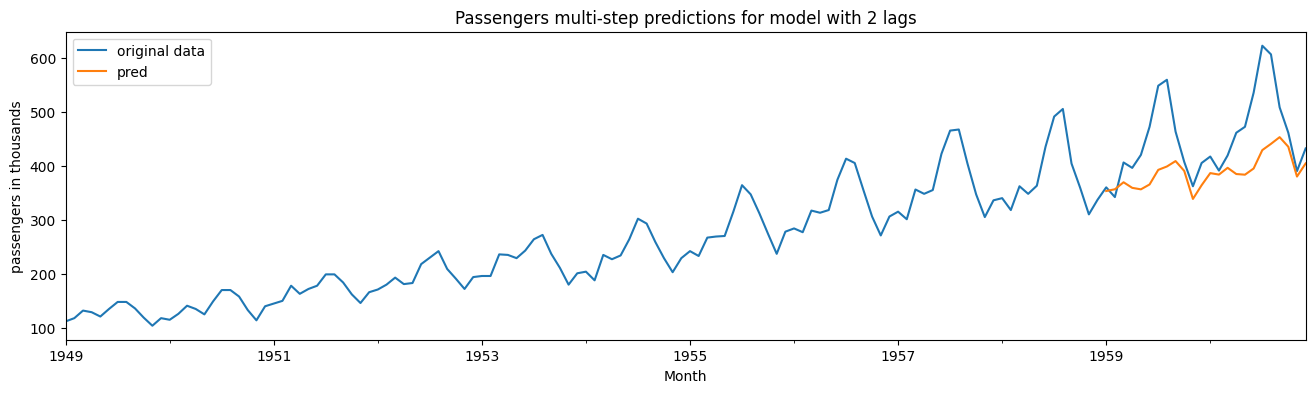

In [38]:
airlines.plot(label="original data")
plt.ylabel('passengers in thousands')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Passengers multi-step predictions for model with 2 lags')
plt.legend();

In [39]:
mean_absolute_error(test,predictions)

65.01691937531352

Uh, that's not great. Remember we achieved around 10.6 using SARIMAX multistep forecast. But we're currently only using 2 lags, and we did see the data had yearly seasonality, so for doing a 24 step forecast we definitely need more context. Let's use the last 24 lags.

In [40]:
predictions = predict_n_periods(series_=train, 
                  n_periods=24, 
                  model=LinearRegression(), 
                  num_periods_lagged=24)

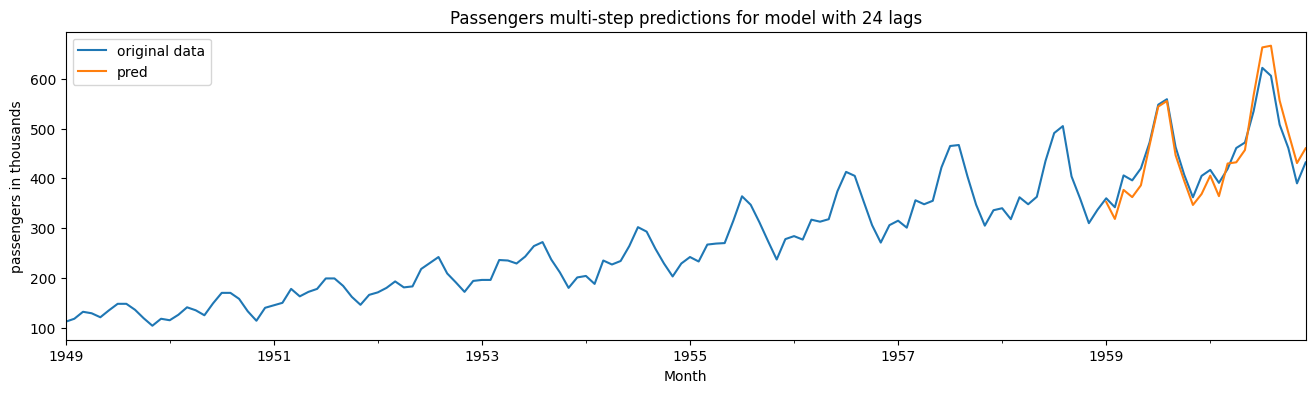

In [41]:
airlines.plot(label="original data")
plt.ylabel('passengers in thousands')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Passengers multi-step predictions for model with 24 lags')
plt.legend();

In [42]:
mean_absolute_error(test,predictions)

24.816356930149237

Nice! That improved significantly! Still, it clearly isn't up to SARIMAX level. Remember that this is quite a well behaved time series, that is quite simple and doesn't have a lot of data. This means it's a great use case for SARIMAX, so it's normal that a simple learning regression doesn't really beat it.

Note: You may have had a feeling that what we were doing is not quite right, because we were tunning the number of features on the test set which is a good recipe for overfitting. Don't worry, on the next notebook we'll take care of that.